In [2]:
import numpy as np
import pandas as pd
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf 
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import kurtosis
from scipy.stats import t

# List of halving dates
halving_dates = [
    pd.Timestamp('2012-11-28'),
    pd.Timestamp('2016-07-09'),
    pd.Timestamp('2020-05-11'),
    pd.Timestamp('2024-04-20'),
]

colors = {
    halving_dates[0].date(): 'maroon',
    halving_dates[1].date(): 'darkgoldenrod',
    halving_dates[2].date(): 'darkgreen',
    halving_dates[3].date(): 'darkblue'
}


In [3]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, acorr_ljungbox
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

def test_residuals_diagnostics(df, model='crypto_capm', n=180, m=3, verbose=True):
    diagnostics = []

    for event_date in halving_dates:
        # Define estimation window
        estimation_start = event_date - timedelta(days=n+m)
        estimation_end = event_date - timedelta(days=m + 1)
        estimation_data = df[(df['date'] >= estimation_start) & (df['date'] <= estimation_end)]

        if len(estimation_data) < 30:
            if verbose:
                print(f"Skipping {event_date.date()} due to insufficient data.")
            continue

        Y = estimation_data['ln_diff'] - estimation_data['rfr']

        if model == 'crypto_capm':
            if estimation_data['crypto_index_diff'].isna().any():
                if verbose:
                    print(f"Skipping {event_date.date()} for crypto_capm due to missing crypto index data.")
                continue
            X = estimation_data['crypto_index_diff'] - estimation_data['rfr']
        elif model == 'sp500_capm':
            X = estimation_data['sp500_diff'] - estimation_data['rfr']
        elif model == 'constant':
            X = None
        else:
            raise ValueError("Invalid model.")

        if model == 'constant':
            residuals = Y - Y.mean()
            bg_stat, bg_pval = np.nan, np.nan
            bp_stat, bp_pval = np.nan, np.nan
            white_stat, white_pval = np.nan, np.nan
        else:
            model_fit = sm.OLS(Y, X).fit()
            residuals = model_fit.resid
            X_for_het = sm.add_constant(X)
            bg_test = acorr_breusch_godfrey(model_fit, nlags=5)
            bg_stat, bg_pval = bg_test[0], bg_test[1]
            bp_stat, bp_pval, _, _ = het_breuschpagan(residuals, X_for_het)
            white_stat, white_pval, _, _ = het_white(residuals, X_for_het)

        # Ljung-Box test (lag 5)
        lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        lb_stat = lb_test.iloc[0, 0]
        lb_pval = lb_test.iloc[0, 1]

        diagnostics.append({
            'halving_date': event_date.date(),
            'model': model,
            'BG(5)': bg_stat,
            'BG(5) pval': bg_pval,
            'LB(5)': lb_stat,
            'LB(5) pval': lb_pval,
            'BP': bp_stat,
            'BP pval': bp_pval,
            'White': white_stat,
            'White pval': white_pval
        })

    return pd.DataFrame(diagnostics)



In [4]:
def event_study(df, model='crypto_capm', n=180, m=3, k=0, verbose=True):
    results = []

    for event_date in halving_dates:
        # Define windows
        estimation_start = event_date - timedelta(days=n + m)
        estimation_end = event_date - timedelta(days=m + 1)
        event_window_start = event_date - timedelta(days=m)
        event_window_end = event_date + timedelta(days=m)
        post_window_start = event_window_end + timedelta(days=1)
        post_window_end = event_window_end + timedelta(days=k)

        # Filter data
        estimation_data = df[(df['date'] >= estimation_start) & (df['date'] <= estimation_end)]
        event_data = df[(df['date'] >= event_window_start) & (df['date'] <= event_window_end)]
        post_event_data = df[(df['date'] >= post_window_start) & (df['date'] <= post_window_end)]

        # Skip if not enough data
        if len(estimation_data) < (n - m) or len(event_data) < (2 * m + 1):
            if verbose:
                print(f"Skipping {event_date.date()} due to insufficient data.")
            continue

        Y = estimation_data['ln_diff'] - estimation_data['rfr']

        if model == 'crypto_capm':
            if 'crypto_index_diff' not in estimation_data or estimation_data['crypto_index_diff'].isna().any():
                if verbose:
                    print(f"Skipping {event_date.date()} for crypto_capm due to missing crypto index data.")
                continue
            X = estimation_data['crypto_index_diff'] - estimation_data['rfr']
            market_excess = event_data['crypto_index_diff'] - event_data['rfr']
            market_excess_post = post_event_data['crypto_index_diff'] - post_event_data['rfr']
        elif model == 'sp500_capm':
            X = estimation_data['sp500_diff'] - estimation_data['rfr']
            market_excess = event_data['sp500_diff'] - event_data['rfr']
            market_excess_post = post_event_data['sp500_diff'] - post_event_data['rfr']
        elif model == 'constant':
            X = None
            market_excess = None
            market_excess_post = None
        else:
            raise ValueError("Invalid model. Choose from 'crypto_capm', 'sp500_capm', 'constant'.")

        if model == 'constant':
            alpha = Y.mean()
            predicted = pd.Series(alpha, index=event_data.index)
            predicted_post = pd.Series(alpha, index=post_event_data.index)
            residuals = estimation_data['ln_diff'] - estimation_data['rfr'] - alpha
            sstat, sp_value = shapiro(residuals)
            K = kurtosis(residuals, fisher=False)  # set fisher=False for normal=3
            print(f"Kurtosis = {K}")
            print(f"Shapiro-Wilk test statistic = {sstat}, p-value = {sp_value}")
        else:
            model_fit = sm.OLS(Y, X).fit()
            beta = model_fit.params[0]
            predicted = beta * market_excess
            predicted_post = beta * market_excess_post
            residuals = model_fit.resid

            X_2 = sm.add_constant(X)
            model_test = sm.OLS(Y, X_2).fit()
            robust_test = model_test.get_robustcov_results(cov_type='HAC', maxlags=4)
            pval_intercept = robust_test.pvalues[0]
            pval_slope = robust_test.pvalues[1]
            sstat, sp_value = shapiro(residuals)
            K = kurtosis(residuals, fisher=True)  # set fisher=False for normal=3
            print(f"Kurtosis = {K}")
            print(f"Shapiro-Wilk test statistic = {sstat}, p-value = {sp_value}")

            # Optional print of HAC t-stats for beta
            robust_fit = model_fit.get_robustcov_results(cov_type='HAC', maxlags=4)
            robust_beta = robust_fit.params[0]
            robust_se = robust_fit.bse[0]
            robust_t = robust_beta / robust_se


        actual_excess = event_data['ln_diff'] - event_data['rfr']
        abnormal_returns = actual_excess - predicted
        car = abnormal_returns.sum()

        std_err = residuals.std(ddof=1)
        se_car = std_err * np.sqrt(len(abnormal_returns))
        t_stat = car / se_car if se_car > 0 else np.nan

        # Post-event CAR and t-stat
        actual_excess_post = post_event_data['ln_diff'] - post_event_data['rfr']
        abnormal_returns_post = actual_excess_post - predicted_post
        car_post = abnormal_returns_post.sum()
        se_car_post = std_err * np.sqrt(len(abnormal_returns_post))
        t_stat_post = car_post / se_car_post if se_car_post > 0 else np.nan

        results.append({
            'halving_date': event_date.date(),
            'model': model,
            'CAR': car,
            'SE(CAR)': se_car,
            't-stat': t_stat,
            'Post-CAR': car_post,
            'SE(Post-CAR)': se_car_post,
            't-stat Post': t_stat_post,
            'n': n,
            'm': m,
            'k': k,
            "error": std_err
        })

    return pd.DataFrame(results)


In [5]:
# Load CSVs
btc_df = pd.read_csv('btc.csv')
crypto_index_df = pd.read_csv('crypto_index.csv')
rfr_df = pd.read_csv('rfr.csv')
sp500_df = pd.read_csv('sp500.csv')

rfr_df["rfr"] = np.log((rfr_df["rfr"]/100 + 1)**(1/365))

# Parse dates
btc_df['time'] = pd.to_datetime(btc_df['time'], dayfirst=True)
btc_df = btc_df.sort_values('time')
btc_df['ln_diff'] = np.log(btc_df['close']).diff()
btc_df.rename(columns={'time': 'date'}, inplace=True)

crypto_index_df['date'] = pd.to_datetime(crypto_index_df['date'], dayfirst=True)
rfr_df.rename(columns={'observation_date': 'date'}, inplace=True)
rfr_df['date'] = pd.to_datetime(rfr_df['date'], dayfirst=True)
sp500_df['date'] = pd.to_datetime(sp500_df['date'], dayfirst=True)

full_dates = pd.DataFrame({'date': pd.date_range(btc_df['date'].min(), btc_df['date'].max())})
rfr_df = full_dates.merge(rfr_df, on='date', how='left').fillna(method='ffill')
sp500_df = full_dates.merge(sp500_df, on='date', how='left').fillna(method='ffill')

# Step 1: Merge BTC, S&P500, and RFR first — they have early data
merged_df = (
    btc_df[['date', 'ln_diff']]
    .merge(sp500_df[['date', 'sp500_diff']], on='date', how='left')
    .merge(rfr_df[['date', 'rfr']], on='date', how='left')
)

# Step 2: Merge crypto index using a left join (so pre-2013 dates are retained)
merged_df = merged_df.merge(crypto_index_df[['date', 'crypto_index_diff']], on='date', how='left')

# Step 3: Drop rows missing required data for all models (but keep NaN in crypto_index_diff)
merged_df = merged_df.dropna(subset=['ln_diff', 'rfr'])

# Step 4: Ensure all relevant columns are numeric
cols_to_convert = ['ln_diff', 'crypto_index_diff', 'sp500_diff', 'rfr']
merged_df[cols_to_convert] = merged_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Sort and reset index
merged_df = merged_df.sort_values('date').reset_index(drop=True)


/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/3663966144.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rfr_df = full_dates.merge(rfr_df, on='date', how='left').fillna(method='ffill')
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/3663966144.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp500_df = full_dates.merge(sp500_df, on='date', how='left').fillna(method='ffill')


In [6]:
event_study(merged_df, model='crypto_capm', n=180, m=2, k=160)

Skipping 2012-11-28 for crypto_capm due to missing crypto index data.
Kurtosis = 9.355714372371574
Shapiro-Wilk test statistic = 0.8257489241025282, p-value = 2.1369083257391908e-13
Kurtosis = 42.718483842840556
Shapiro-Wilk test statistic = 0.679928350001038, p-value = 2.856746419419657e-18
Kurtosis = 1.6091310907034293
Shapiro-Wilk test statistic = 0.9636045041087269, p-value = 0.00012483084278543127


/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/914464310.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/914464310.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/914464310.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,halving_date,model,CAR,SE(CAR),t-stat,Post-CAR,SE(Post-CAR),t-stat Post,n,m,k,error
0,2016-07-09,crypto_capm,-0.038055,0.066740,-0.570206,0.193999,0.377537,0.513853,180,2,160,0.029847
1,2020-05-11,crypto_capm,-0.052268,0.117191,-0.446009,0.238755,0.662930,0.360151,180,2,160,0.052409
2,2024-04-20,crypto_capm,0.096819,0.063981,1.513255,-0.049975,0.361931,-0.138078,180,2,160,0.028613


In [7]:
event_study(merged_df, model='sp500_capm', n=180, m=2, k=160)

Kurtosis = 38.08472384381665
Shapiro-Wilk test statistic = 0.6598308153705479, p-value = 8.356692281994446e-19
Kurtosis = 9.167804347151375
Shapiro-Wilk test statistic = 0.8280390111708102, p-value = 2.67070839020048e-13
Kurtosis = 30.258990929525332
Shapiro-Wilk test statistic = 0.7494511516163704, p-value = 3.3000880037538546e-16
Kurtosis = 1.5459306294795105
Shapiro-Wilk test statistic = 0.9705033633683187, p-value = 0.0007322562669219904


/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/914464310.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/914464310.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/914464310.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,halving_date,model,CAR,SE(CAR),t-stat,Post-CAR,SE(Post-CAR),t-stat Post,n,m,k,error
0,2012-11-28,sp500_capm,0.009309,0.091075,0.102210,2.179473,0.515198,4.230364,180,2,160,0.040730
1,2016-07-09,sp500_capm,-0.037305,0.066763,-0.558763,0.193872,0.377671,0.513334,180,2,160,0.029858
2,2020-05-11,sp500_capm,-0.047222,0.108238,-0.436280,0.025256,0.612285,0.041249,180,2,160,0.048405
3,2024-04-20,sp500_capm,0.093579,0.064636,1.447784,-0.119506,0.365635,-0.326845,180,2,160,0.028906


In [8]:
event_study(merged_df, model='constant', n=180, m=2, k=160)

Kurtosis = 41.066176837677126
Shapiro-Wilk test statistic = 0.6603241839078751, p-value = 8.607054051539591e-19
Kurtosis = 12.10397408247266
Shapiro-Wilk test statistic = 0.8281266399915144, p-value = 2.6937033185921063e-13
Kurtosis = 45.709840213444316
Shapiro-Wilk test statistic = 0.6793237084778281, p-value = 2.7507594793240155e-18
Kurtosis = 4.602230693997136
Shapiro-Wilk test statistic = 0.9657744259642822, p-value = 0.0002142124339225588


,halving_date,model,CAR,SE(CAR),t-stat,Post-CAR,SE(Post-CAR),t-stat Post,n,m,k,error
0,2012-11-28,constant,-0.014731,0.091066,-0.161758,1.416635,0.515149,2.749951,180,2,160,0.040726
1,2016-07-09,constant,-0.049432,0.066767,-0.740362,-0.160447,0.377692,-0.424808,180,2,160,0.029859
2,2020-05-11,constant,-0.053005,0.117331,-0.451754,0.177363,0.663723,0.267224,180,2,160,0.052472
3,2024-04-20,constant,0.066979,0.064763,1.034231,-0.662647,0.366353,-1.808768,180,2,160,0.028963


In [9]:
test_residuals_diagnostics(merged_df, model='sp500_capm', n=180, m=2)

,halving_date,model,BG(5),BG(5) pval,LB(5),LB(5) pval,BP,BP pval,White,White pval
0,2012-11-28,sp500_capm,5.085154,0.405577,7.840367,0.644426,0.000314,0.985871,1.096063,5.780865e-01
1,2016-07-09,sp500_capm,6.584332,0.253434,16.826591,0.078290,4.446774,0.034967,5.345646,6.905702e-02
2,2020-05-11,sp500_capm,18.534389,0.002346,29.802784,0.000923,10.925004,0.000949,37.245891,8.168785e-09
3,2024-04-20,sp500_capm,5.476259,0.360556,9.352848,0.498976,1.921259,0.165718,2.105940,3.489000e-01


In [10]:
test_residuals_diagnostics(merged_df, model='crypto_capm', n=180, m=2)

Skipping 2012-11-28 for crypto_capm due to missing crypto index data.


,halving_date,model,BG(5),BG(5) pval,LB(5),LB(5) pval,BP,BP pval,White,White pval
0,2016-07-09,crypto_capm,6.761777,0.238969,17.976383,0.055363,7.539139,0.006037,12.898074,0.001582
1,2020-05-11,crypto_capm,16.713382,0.005077,26.517185,0.003103,0.063110,0.801647,0.372996,0.829860
2,2024-04-20,crypto_capm,2.156872,0.827041,7.800653,0.648302,0.823836,0.364061,1.674266,0.432950


In [11]:
test_residuals_diagnostics(merged_df, model='constant', n=180, m=2)

,halving_date,model,BG(5),BG(5) pval,LB(5),LB(5) pval,BP,BP pval,White,White pval
0,2012-11-28,constant,NaN,NaN,7.567682,0.670983,NaN,NaN,NaN,NaN
1,2016-07-09,constant,NaN,NaN,16.832296,0.078158,NaN,NaN,NaN,NaN
2,2020-05-11,constant,NaN,NaN,29.259029,0.001131,NaN,NaN,NaN,NaN
3,2024-04-20,constant,NaN,NaN,8.633990,0.567155,NaN,NaN,NaN,NaN


In [12]:
def event_study(df, model='crypto_capm', n=180, m=2, k=160, verbose=True):
    results = []
    car_paths = {}        # event window abnormal returns
    car_paths_post = {}   # post-event window abnormal returns

    for event_date in halving_dates:
        estimation_start = event_date - timedelta(days=n + m)
        estimation_end = event_date - timedelta(days=m + 1)
        event_window_start = event_date - timedelta(days=m)
        event_window_end = event_date + timedelta(days=m)
        post_window_start = event_window_end + timedelta(days=1)
        post_window_end = event_window_end + timedelta(days=k)

        estimation_data = df[(df['date'] >= estimation_start) & (df['date'] <= estimation_end)]
        event_data = df[(df['date'] >= event_window_start) & (df['date'] <= event_window_end)]
        post_event_data = df[(df['date'] >= post_window_start) & (df['date'] <= post_window_end)]

        if len(estimation_data) < (n - m) or len(event_data) < (2 * m + 1):
            if verbose:
                print(f"Skipping {event_date.date()} due to insufficient data.")
            continue

        Y = estimation_data['ln_diff'] - estimation_data['rfr']

        if model == 'crypto_capm':
            if 'crypto_index_diff' not in estimation_data or estimation_data['crypto_index_diff'].isna().any():
                if verbose:
                    print(f"Skipping {event_date.date()} for crypto_capm due to missing crypto index data.")
                continue
            X = estimation_data['crypto_index_diff'] - estimation_data['rfr']
            market_excess = event_data['crypto_index_diff'] - event_data['rfr']
            market_excess_post = post_event_data['crypto_index_diff'] - post_event_data['rfr']
        elif model == 'sp500_capm':
            X = estimation_data['sp500_diff'] - estimation_data['rfr']
            market_excess = event_data['sp500_diff'] - event_data['rfr']
            market_excess_post = post_event_data['sp500_diff'] - post_event_data['rfr']
        elif model == 'constant':
            X = None
            market_excess = None
            market_excess_post = None
        else:
            raise ValueError("Invalid model. Choose from 'crypto_capm', 'sp500_capm', 'constant'.")

        if model == 'constant':
            alpha = Y.mean()
            predicted = pd.Series(alpha, index=event_data.index)
            predicted_post = pd.Series(alpha, index=post_event_data.index)
            residuals = estimation_data['ln_diff'] - estimation_data['rfr'] - alpha
        else:
            model_fit = sm.OLS(Y, X).fit()
            beta = model_fit.params[0]
            predicted = beta * market_excess
            predicted_post = beta * market_excess_post
            residuals = model_fit.resid

            X_2 = sm.add_constant(X)
            model_test = sm.OLS(Y, X_2).fit()
            robust_test = model_test.get_robustcov_results(cov_type='HAC', maxlags=4)
            pval_intercept = robust_test.pvalues[0]
            pval_slope = robust_test.pvalues[1]
            print(pval_intercept, pval_slope)

            robust_fit = model_fit.get_robustcov_results(cov_type='HAC', maxlags=4)
            robust_beta = robust_fit.params[0]
            robust_se = robust_fit.bse[0]
            robust_t = robust_beta / robust_se
            if verbose:
                print(f"{event_date.date()} | {model} | HAC beta = {robust_beta:.4f}, SE = {robust_se:.4f}, t = {robust_t:.2f}")

        actual_excess = event_data['ln_diff'] - event_data['rfr']
        abnormal_returns = actual_excess - predicted
        car = abnormal_returns.sum()

        # Store event window abnormal returns by relative day
        event_days = np.arange(-m, m+1)
        car_paths[event_date.date()] = pd.Series(abnormal_returns.values, index=event_days)

        std_err = residuals.std(ddof=1)
        se_car = std_err * np.sqrt(len(abnormal_returns))
        t_stat = car / se_car if se_car > 0 else np.nan

        actual_excess_post = post_event_data['ln_diff'] - post_event_data['rfr']
        abnormal_returns_post = actual_excess_post - predicted_post
        car_post = abnormal_returns_post.sum()
        se_car_post = std_err * np.sqrt(len(abnormal_returns_post))
        t_stat_post = car_post / se_car_post if se_car_post > 0 else np.nan

        # Store post-event window abnormal returns
        if k > 0 and len(abnormal_returns_post) > 0:
            post_days = np.arange(1, 1 + len(abnormal_returns_post))
            car_paths_post[event_date.date()] = pd.Series(abnormal_returns_post.values, index=post_days)

        results.append({
            'halving_date': event_date.date(),
            'model': model,
            'CAR': car,
            'SE(CAR)': se_car,
            't-stat': t_stat,
            'Post-CAR': car_post,
            'SE(Post-CAR)': se_car_post,
            't-stat Post': t_stat_post,
            'n': n,
            'm': m,
            'k': k
        })

    return pd.DataFrame(results), car_paths, car_paths_post


In [13]:
def plot_individual_cumulative_car(car_paths, car_paths_post=None):
    """
    Plots individual cumulative CAR paths for each halving event.
    No averaging, no confidence intervals.
    """
    plt.figure(figsize=(12, 6), dpi=300)

    for event in car_paths.keys():
        event_ar = car_paths[event].sort_index()
        event_car = event_ar.cumsum()

        if car_paths_post and event in car_paths_post:
            post_ar = car_paths_post[event].sort_index()
            post_car = post_ar.cumsum() + event_car.iloc[-1]
            combined_days = np.concatenate([event_car.index.values, post_car.index.values])
            combined_car = np.concatenate([event_car.values, post_car.values])
        else:
            combined_days = event_car.index.values
            combined_car = event_car.values

        plt.plot(combined_days, combined_car, linewidth=2, label=f'Halving {event}')

    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.title('Cumulative Abnormal Returns (CAR) for Bitcoin Halvings')
    plt.xlabel('Days relative to halving')
    plt.ylabel('Cumulative Abnormal Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
def plot_custom_mixed_cars(df, halving_dates, k):
    """
    Plots CAR for 1st, 2nd, 4th halving with constant model;
    3rd halving with sp500_capm model.
    All on same plot.
    """
    models = {
        halving_dates[0].date(): 'constant',     # 1st halving
        halving_dates[1].date(): 'constant',     # 2nd halving
        halving_dates[2].date(): 'sp500_capm',   # 3rd halving
        halving_dates[3].date(): 'crypto_capm'      # 4th halving
    }

    plt.figure(figsize=(12, 6), dpi=300)

    for event_date in halving_dates:
        event_key = event_date.date()
        model = models[event_key]

        # Run event study for just this halving
        single_df = df.copy()  # in case your function modifies in-place
        halving_dates    # temporarily override inside function
        halving_dates_backup = halving_dates
        halving_dates = [event_date]

        results, car_paths, car_paths_post = event_study(single_df, model=model, n=180, m=2, k=k, verbose=False)

        # Restore global halving_dates
        halving_dates = halving_dates_backup

        # Plot
        event_ar = car_paths[event_key].sort_index()
        event_car = event_ar.cumsum()


        if event_key in car_paths_post:
            post_ar = car_paths_post[event_key].sort_index()
            post_car = post_ar.cumsum() + event_car.iloc[-1]
            combined_days = np.concatenate([event_car.index.values, post_car.index.values+2])
            combined_car = np.concatenate([event_car.values, post_car.values])
        
        else:
            combined_days = event_car.index.values
            combined_car = event_car.values

        plt.plot(combined_days, combined_car, linewidth=2, color=colors[event_key], label=f'Halving {event_key} ({model})')

    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.title('')
    plt.xlabel('Days relative to halving')
    plt.ylabel('')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
def plot_t(df, halving_dates, divisors, k):
    """
    Plots CAR for 1st, 2nd, 4th halving with constant model;
    3rd halving with sp500_capm model.
    Each series is divided by a custom constant.
    """
    models = {
        halving_dates[0].date(): 'constant',
        halving_dates[1].date(): 'constant',
        halving_dates[2].date(): 'sp500_capm',
        halving_dates[3].date(): 'crypto_capm'
    }

    plt.figure(figsize=(12, 6), dpi=300)
    i = 0
    for event_date in halving_dates:
        event_key = event_date.date()
        model = models[event_key]
        divisor = divisors[event_key]  # 🔥 your custom scaling constant

        single_df = df.copy()
        halving_dates_backup = halving_dates
        halving_dates = [event_date]

        results, car_paths, car_paths_post = event_study(
            single_df, model=model, n=180, m=2, k=k, verbose=False
        )

        halving_dates = halving_dates_backup

        event_ar = car_paths[event_key].sort_index()
        event_car = event_ar.cumsum()

        if event_key in car_paths_post:
            post_ar = car_paths_post[event_key].sort_index()
            post_car = post_ar.cumsum() + event_car.iloc[-1]
            combined_days = np.concatenate([event_car.index.values, post_car.index.values+2])
            combined_car = np.concatenate([event_car.values, post_car.values])
            days = np.arange(1, len(combined_days) + 1)
            combined_car = combined_car/ np.sqrt(days)
        else:
            combined_days = event_car.index.values
            combined_car = event_car.values

        # 🔥 divide this event's CAR by your chosen constant
        combined_car = combined_car / divisor
        t_crit = t.ppf(1 - 0.05/2, df=combined_days+2)
        print(t_crit)
        plt.plot(combined_days, combined_car, linewidth=2, color = colors[event_key], label=f'Halving {event_key} ({model})')
        if i == 0:
            plt.plot(combined_days[2:], t_crit[2:], color='red', linestyle=':', linewidth=1.5, label='5% t critical value')
            plt.plot(combined_days[2:], -t_crit[2:], color='red', linestyle=':', linewidth=1.5)
            i = i + 1
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.title('')
    plt.xlabel('Days after halving')
    plt.ylabel('')
    handles, labels = plt.gca().get_legend_handles_labels()

    # Move second entry (index 1) to the end
    order = [0] + list(range(2, len(handles))) + [1]

    plt.legend([handles[i] for i in order],
            [labels[i] for i in order],
            loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

0.06160836066105656 0.9120042371761505
0.3184914231805836 0.8935618859757525
0.8148000490935838 0.010739585637840983
0.09944522267885468 0.32860375952681486
0.31523333475451265 0.846544670823298
0.9125188522372157 0.09183392412640426
0.09191343601344044 0.06529531839115112


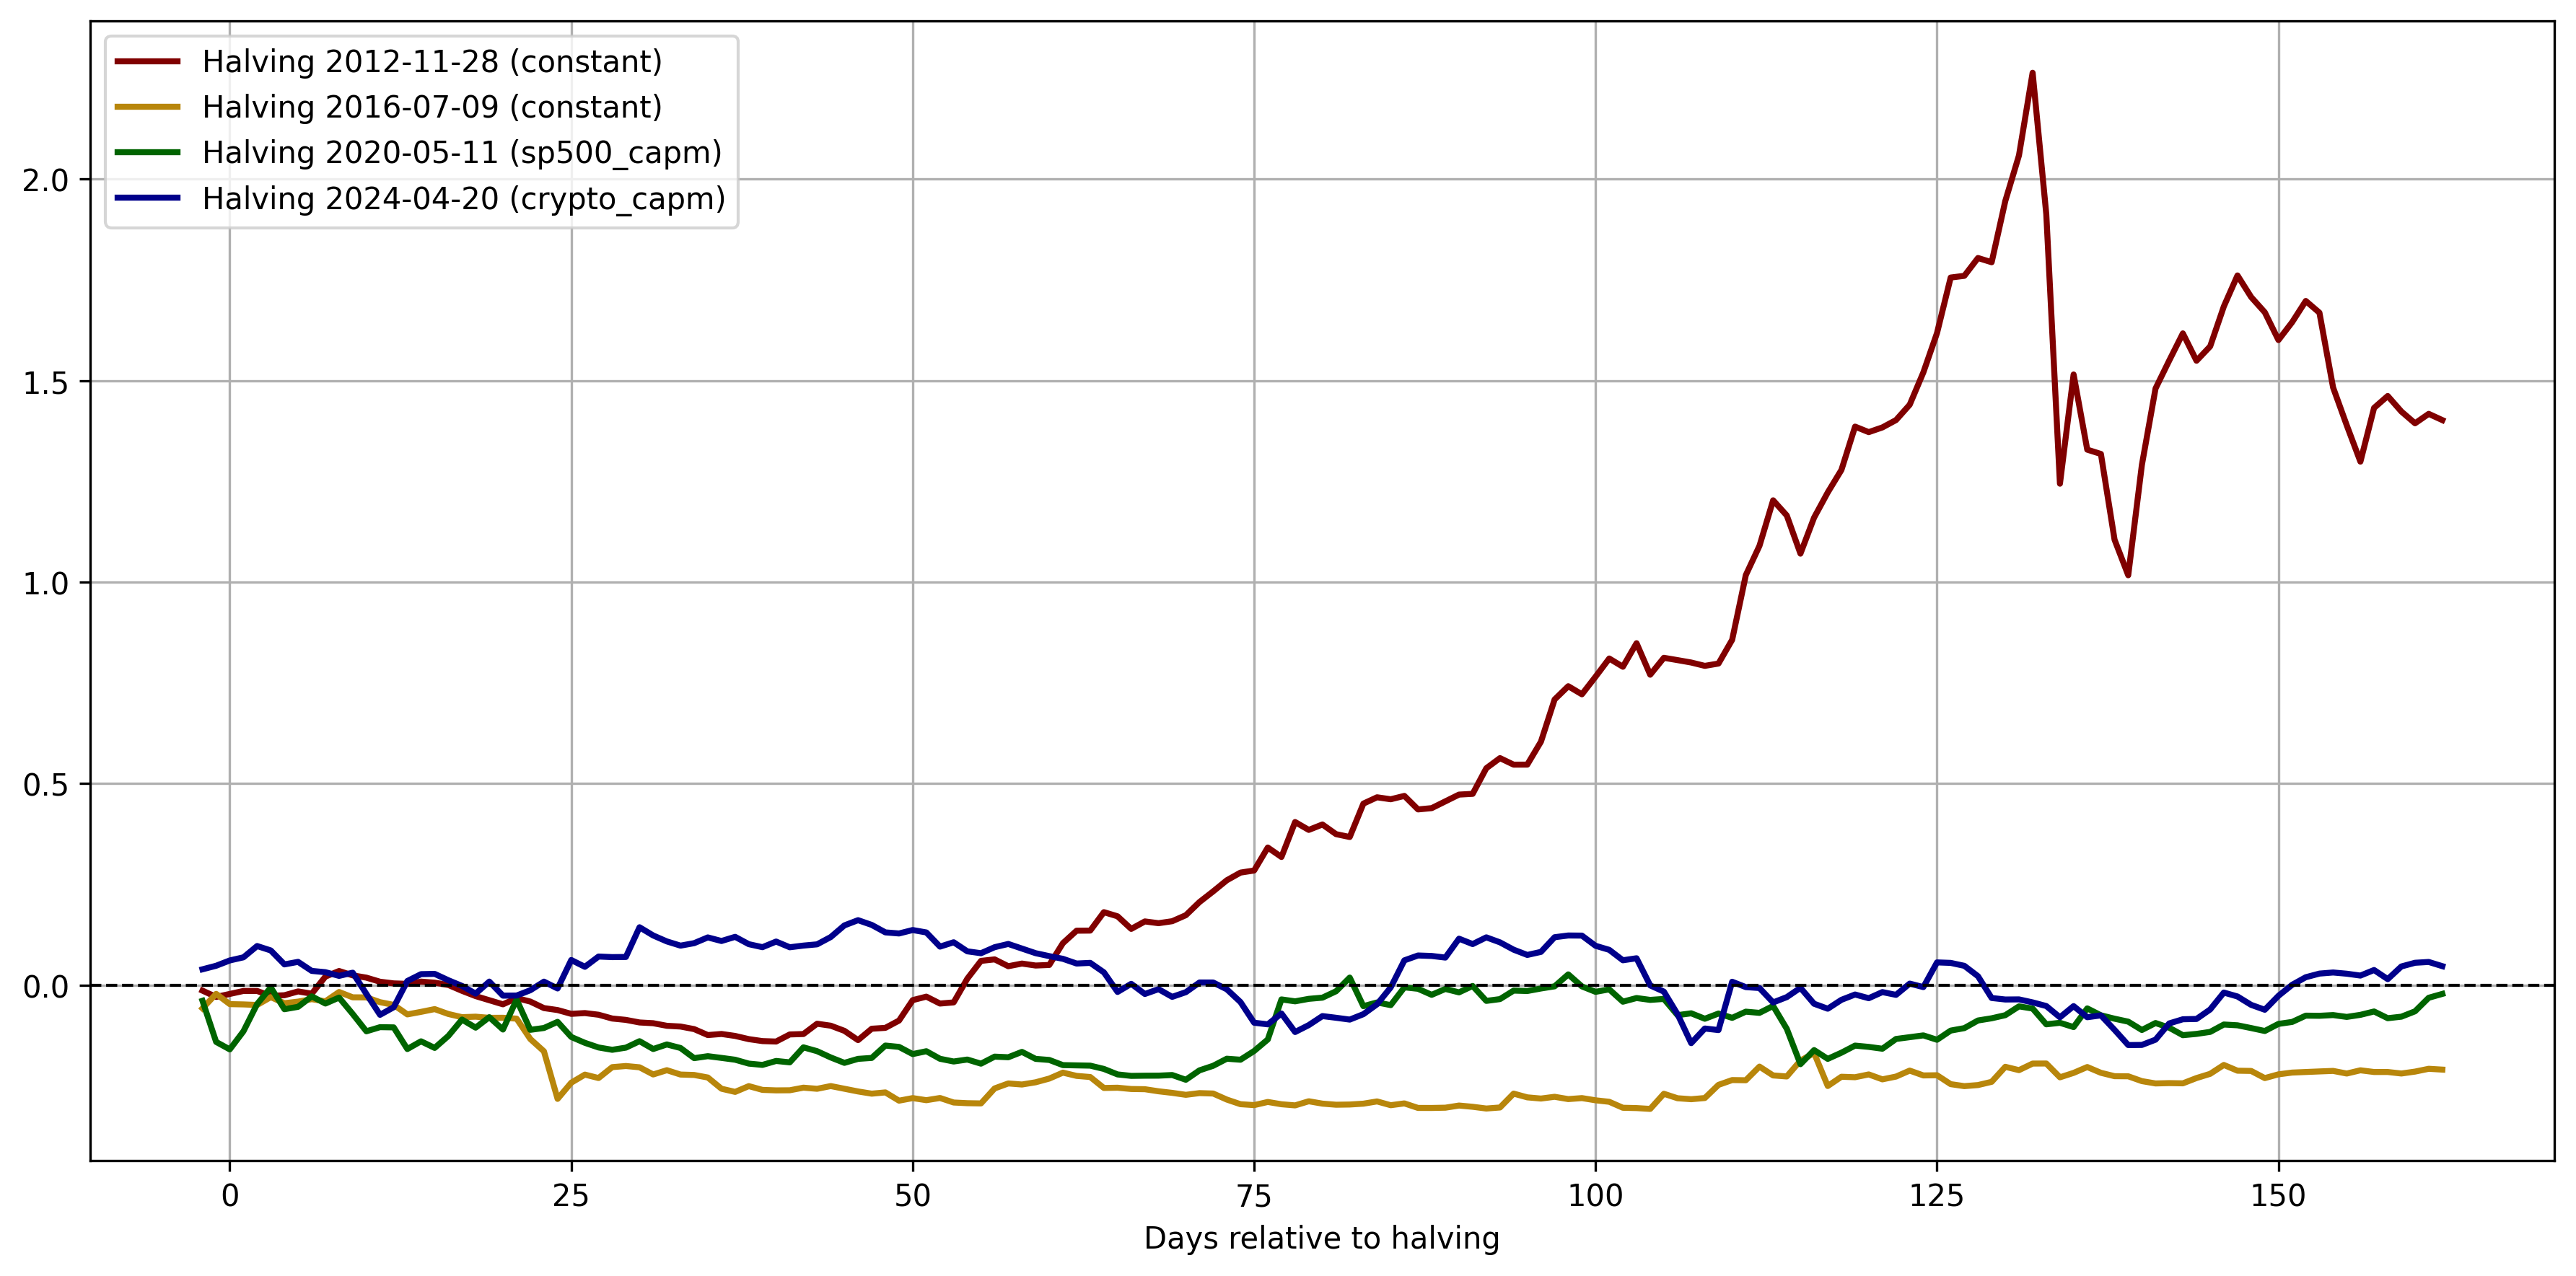

In [16]:
plot_custom_mixed_cars(merged_df, halving_dates, 160)

/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

0.06160836066105656 0.9120042371761505
0.3184914231805836 0.8935618859757525
0.8148000490935838 0.010739585637840983
0.09944522267885468 0.32860375952681486
0.31523333475451265 0.846544670823298
0.9125188522372157 0.09183392412640426
0.09191343601344044 0.06529531839115112


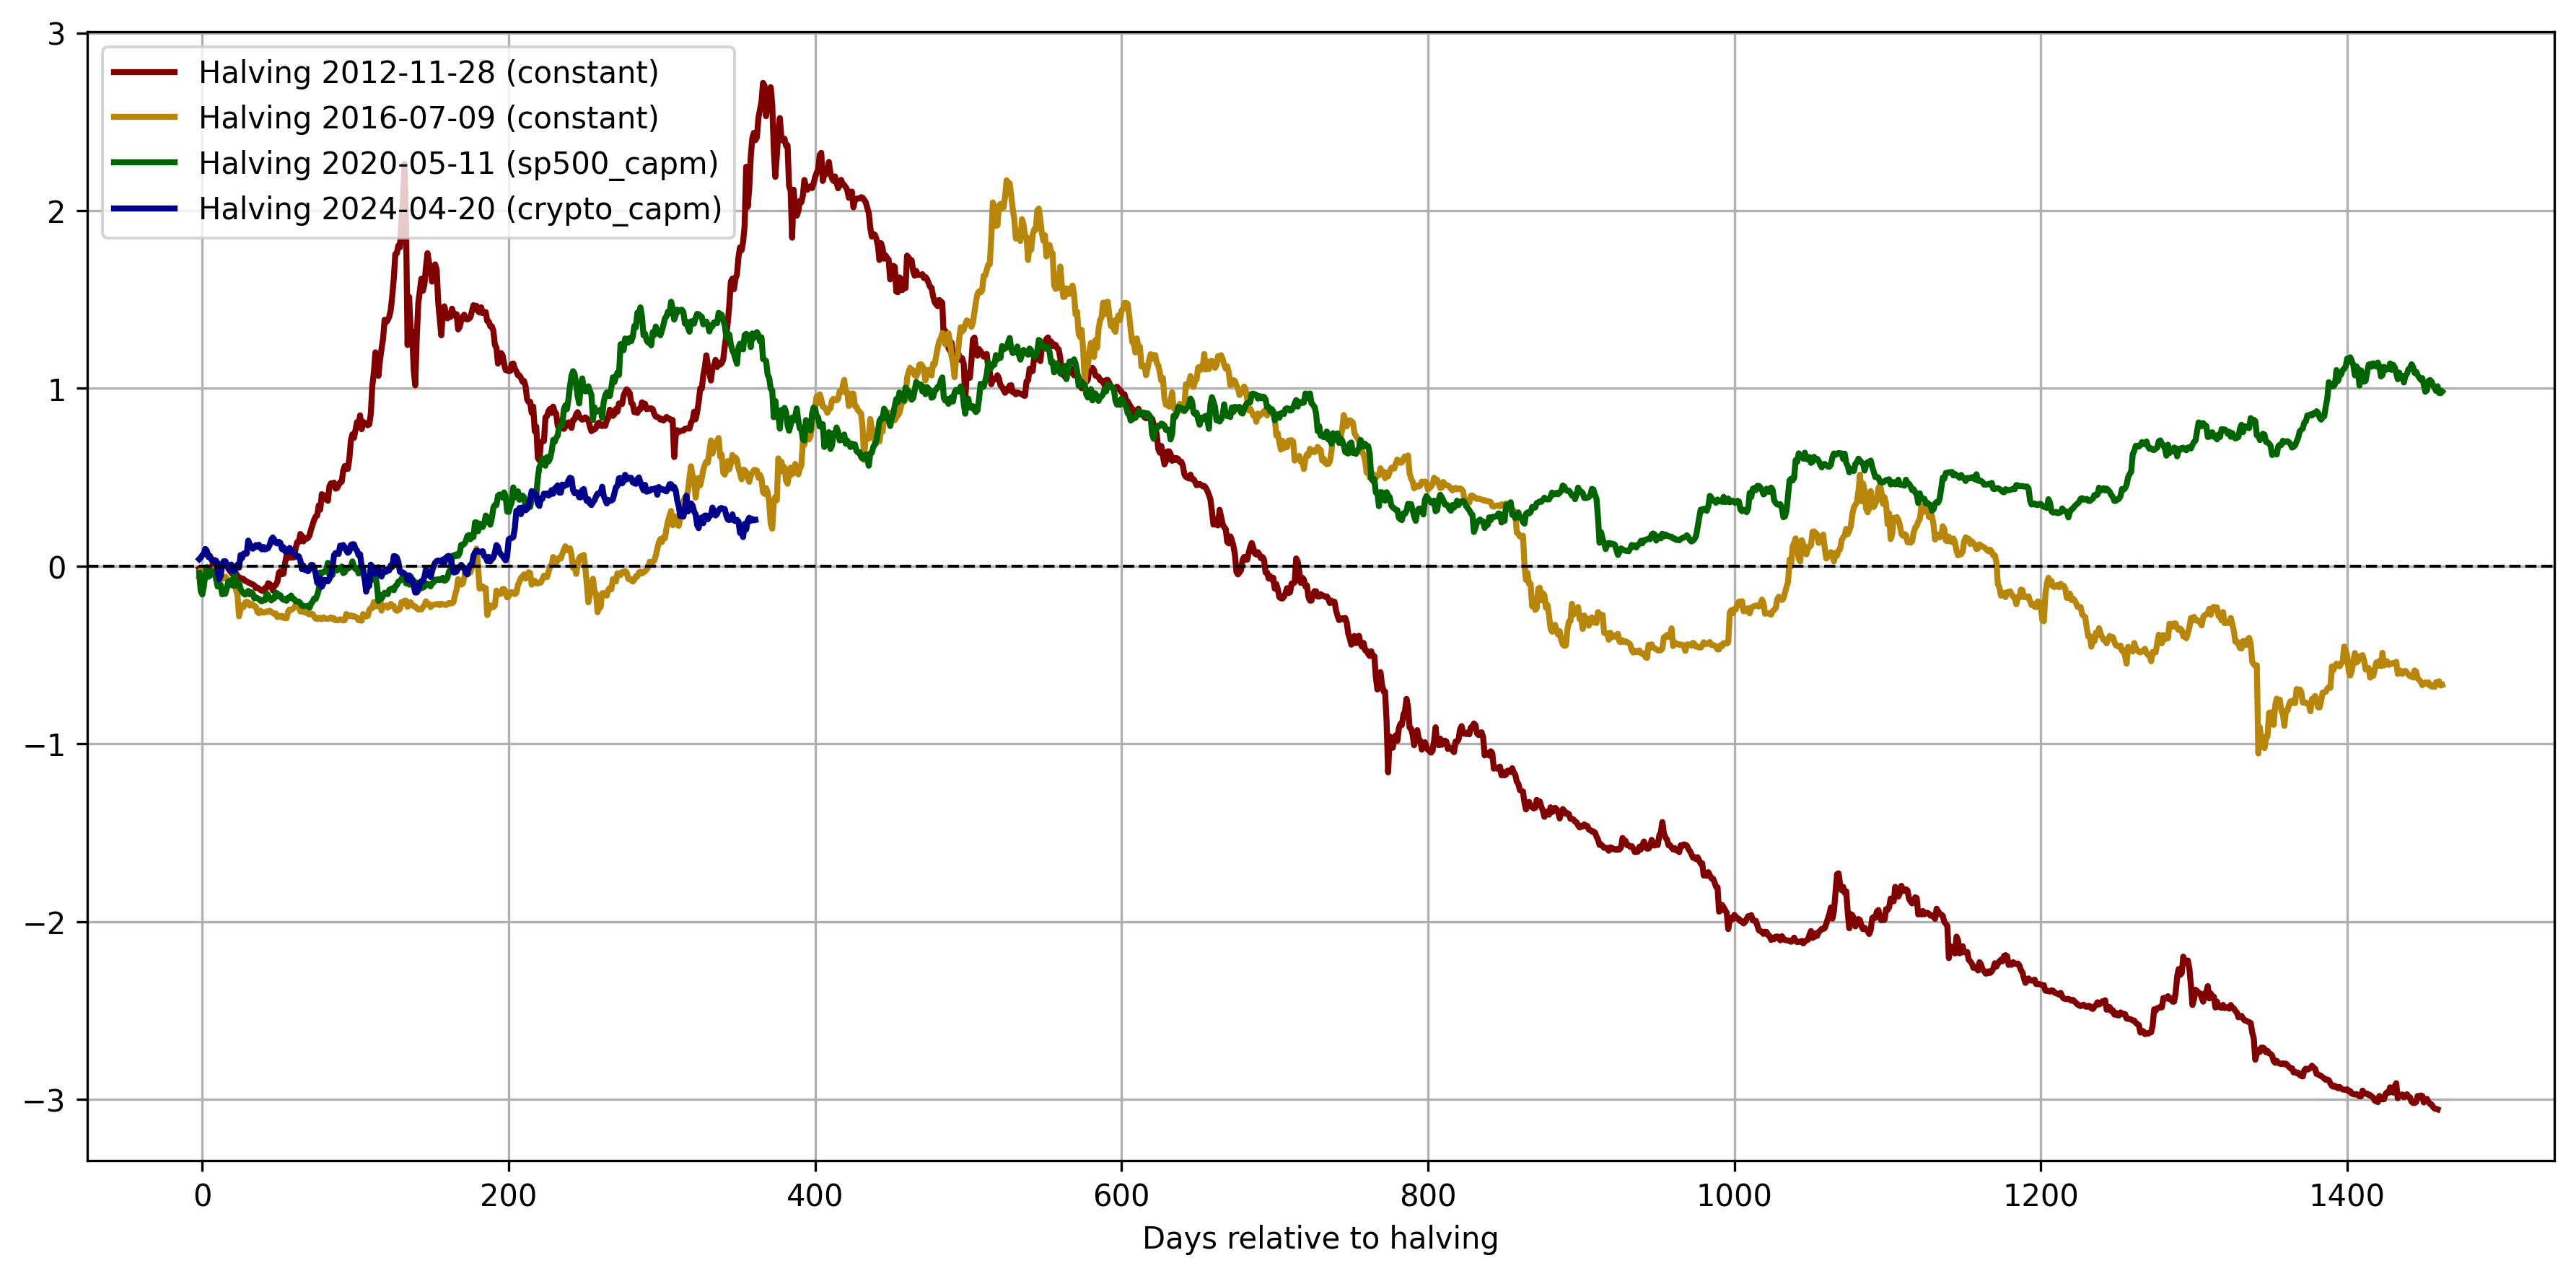

In [25]:
plot_custom_mixed_cars(merged_df, halving_dates, 1460)

[        nan 12.70620474  4.30265273  3.18244631  2.77644511  2.57058184
  2.44691185  2.36462425  2.30600414  2.26215716  2.22813885  2.20098516
  2.17881283  2.16036866  2.14478669  2.13144955  2.1199053   2.10981558
  2.10092204  2.09302405  2.08596345  2.07961384  2.07387307  2.06865761
  2.06389856  2.05953855  2.05552944  2.05183052  2.04840714  2.04522964
  2.04227246  2.03951345  2.03693334  2.0345153   2.03224451  2.03010793
  2.028094    2.02619246  2.02439416  2.02269092  2.02107539  2.01954097
  2.0180817   2.0166922   2.01536757  2.01410339  2.0128956   2.01174051
  2.01063476  2.00957524  2.00855911  2.00758377  2.00664681  2.005746
  2.00487929  2.00404478  2.00324072  2.00246546  2.00171748  2.00099538
  2.00029782  1.99962358  1.99897152  1.99834054  1.99772965  1.99713791
  1.99656442  1.99600835  1.99546893  1.99494542  1.99443711  1.99394337
  1.99346357  1.99299713  1.9925435   1.99210215  1.99167261  1.9912544
  1.99084707  1.99045021  1.99006342  1.98968632  1.98

/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

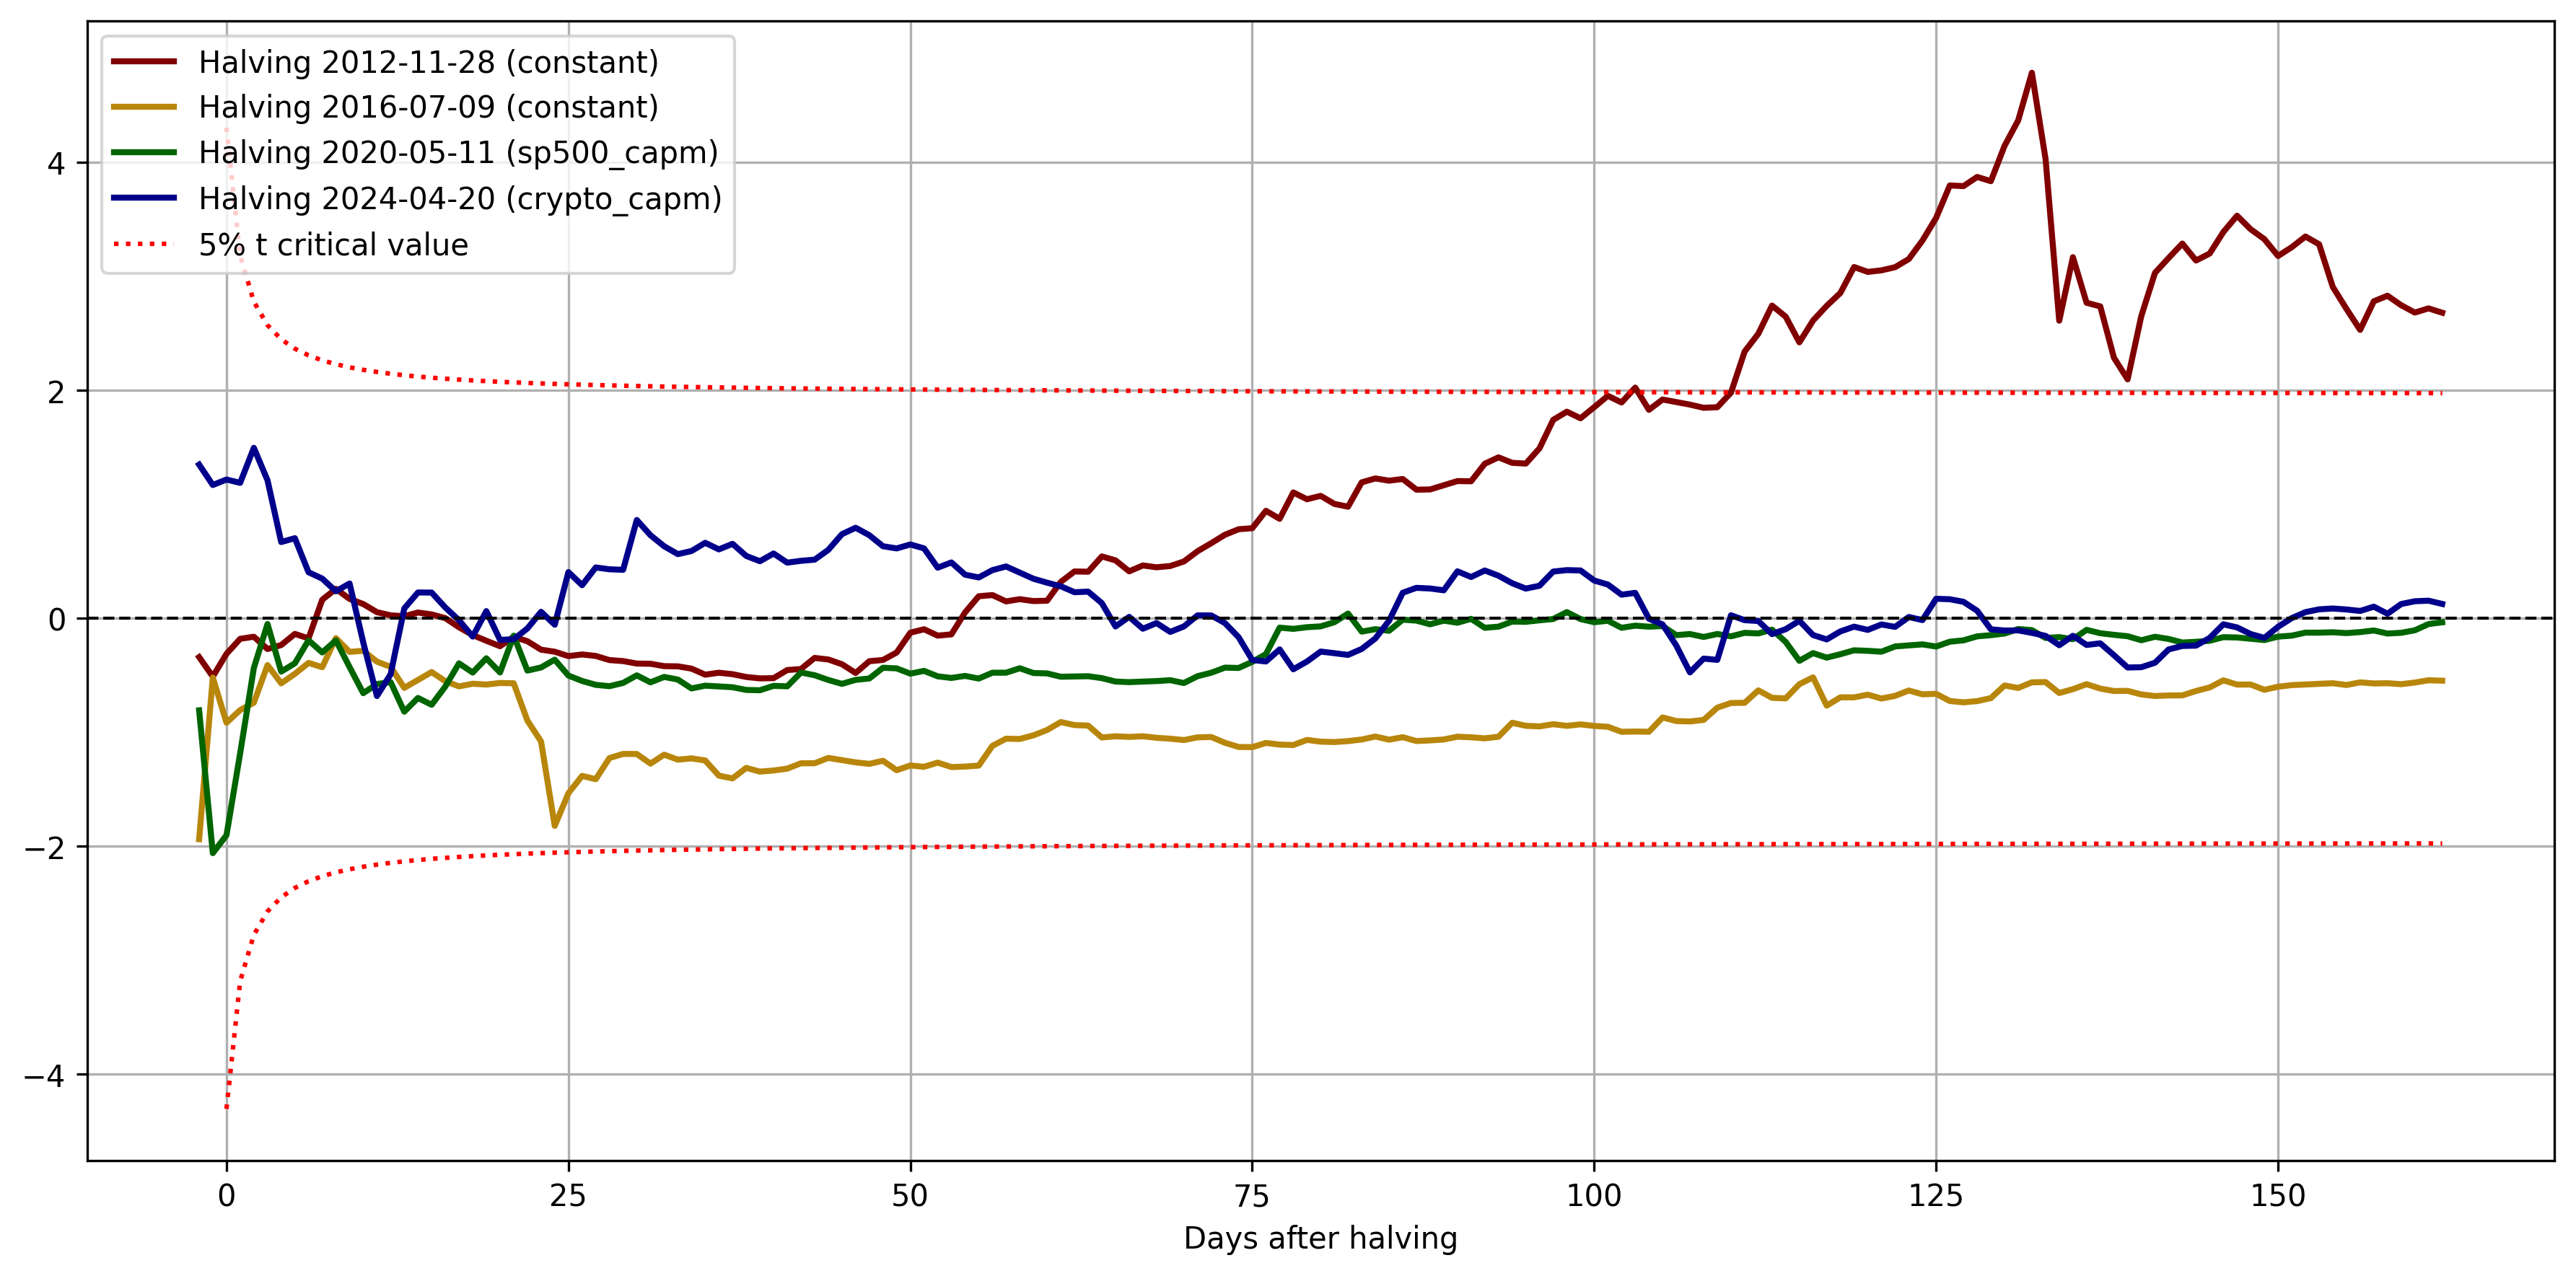

In [18]:
divisors = {
    halving_dates[0].date(): 0.040726,   # 1st halving
    halving_dates[1].date(): 0.029859,   # 2nd halving
    halving_dates[2].date(): 0.048465,   # 3rd halving
    halving_dates[3].date(): 0.028963   # 4th halving
}

plot_t(merged_df, halving_dates, divisors, 160)

[        nan 12.70620474  4.30265273 ...  1.96159127  1.96159015
  1.96158904]
[        nan 12.70620474  4.30265273 ...  1.96158793  1.96158682
  1.96158571]
0.06160836066105656 0.9120042371761505
0.3184914231805836 0.8935618859757525
0.8148000490935838 0.010739585637840983
0.09944522267885468 0.32860375952681486
[        nan 12.70620474  4.30265273 ...  1.96158793  1.96158682
  1.96158571]
0.31523333475451265 0.846544670823298
0.9125188522372157 0.09183392412640426
0.09191343601344044 0.06529531839115112
[        nan 12.70620474  4.30265273  3.18244631  2.77644511  2.57058184
  2.44691185  2.36462425  2.30600414  2.26215716  2.22813885  2.20098516
  2.17881283  2.16036866  2.14478669  2.13144955  2.1199053   2.10981558
  2.10092204  2.09302405  2.08596345  2.07961384  2.07387307  2.06865761
  2.06389856  2.05953855  2.05552944  2.05183052  2.04840714  2.04522964
  2.04227246  2.03951345  2.03693334  2.0345153   2.03224451  2.03010793
  2.028094    2.02619246  2.02439416  2.02269092  2

/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model_fit.params[0]
/var/folders/04/5gzpw57x2dz6l5fs4drprf_h0000gn/T/ipykernel_96141/1424525177.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

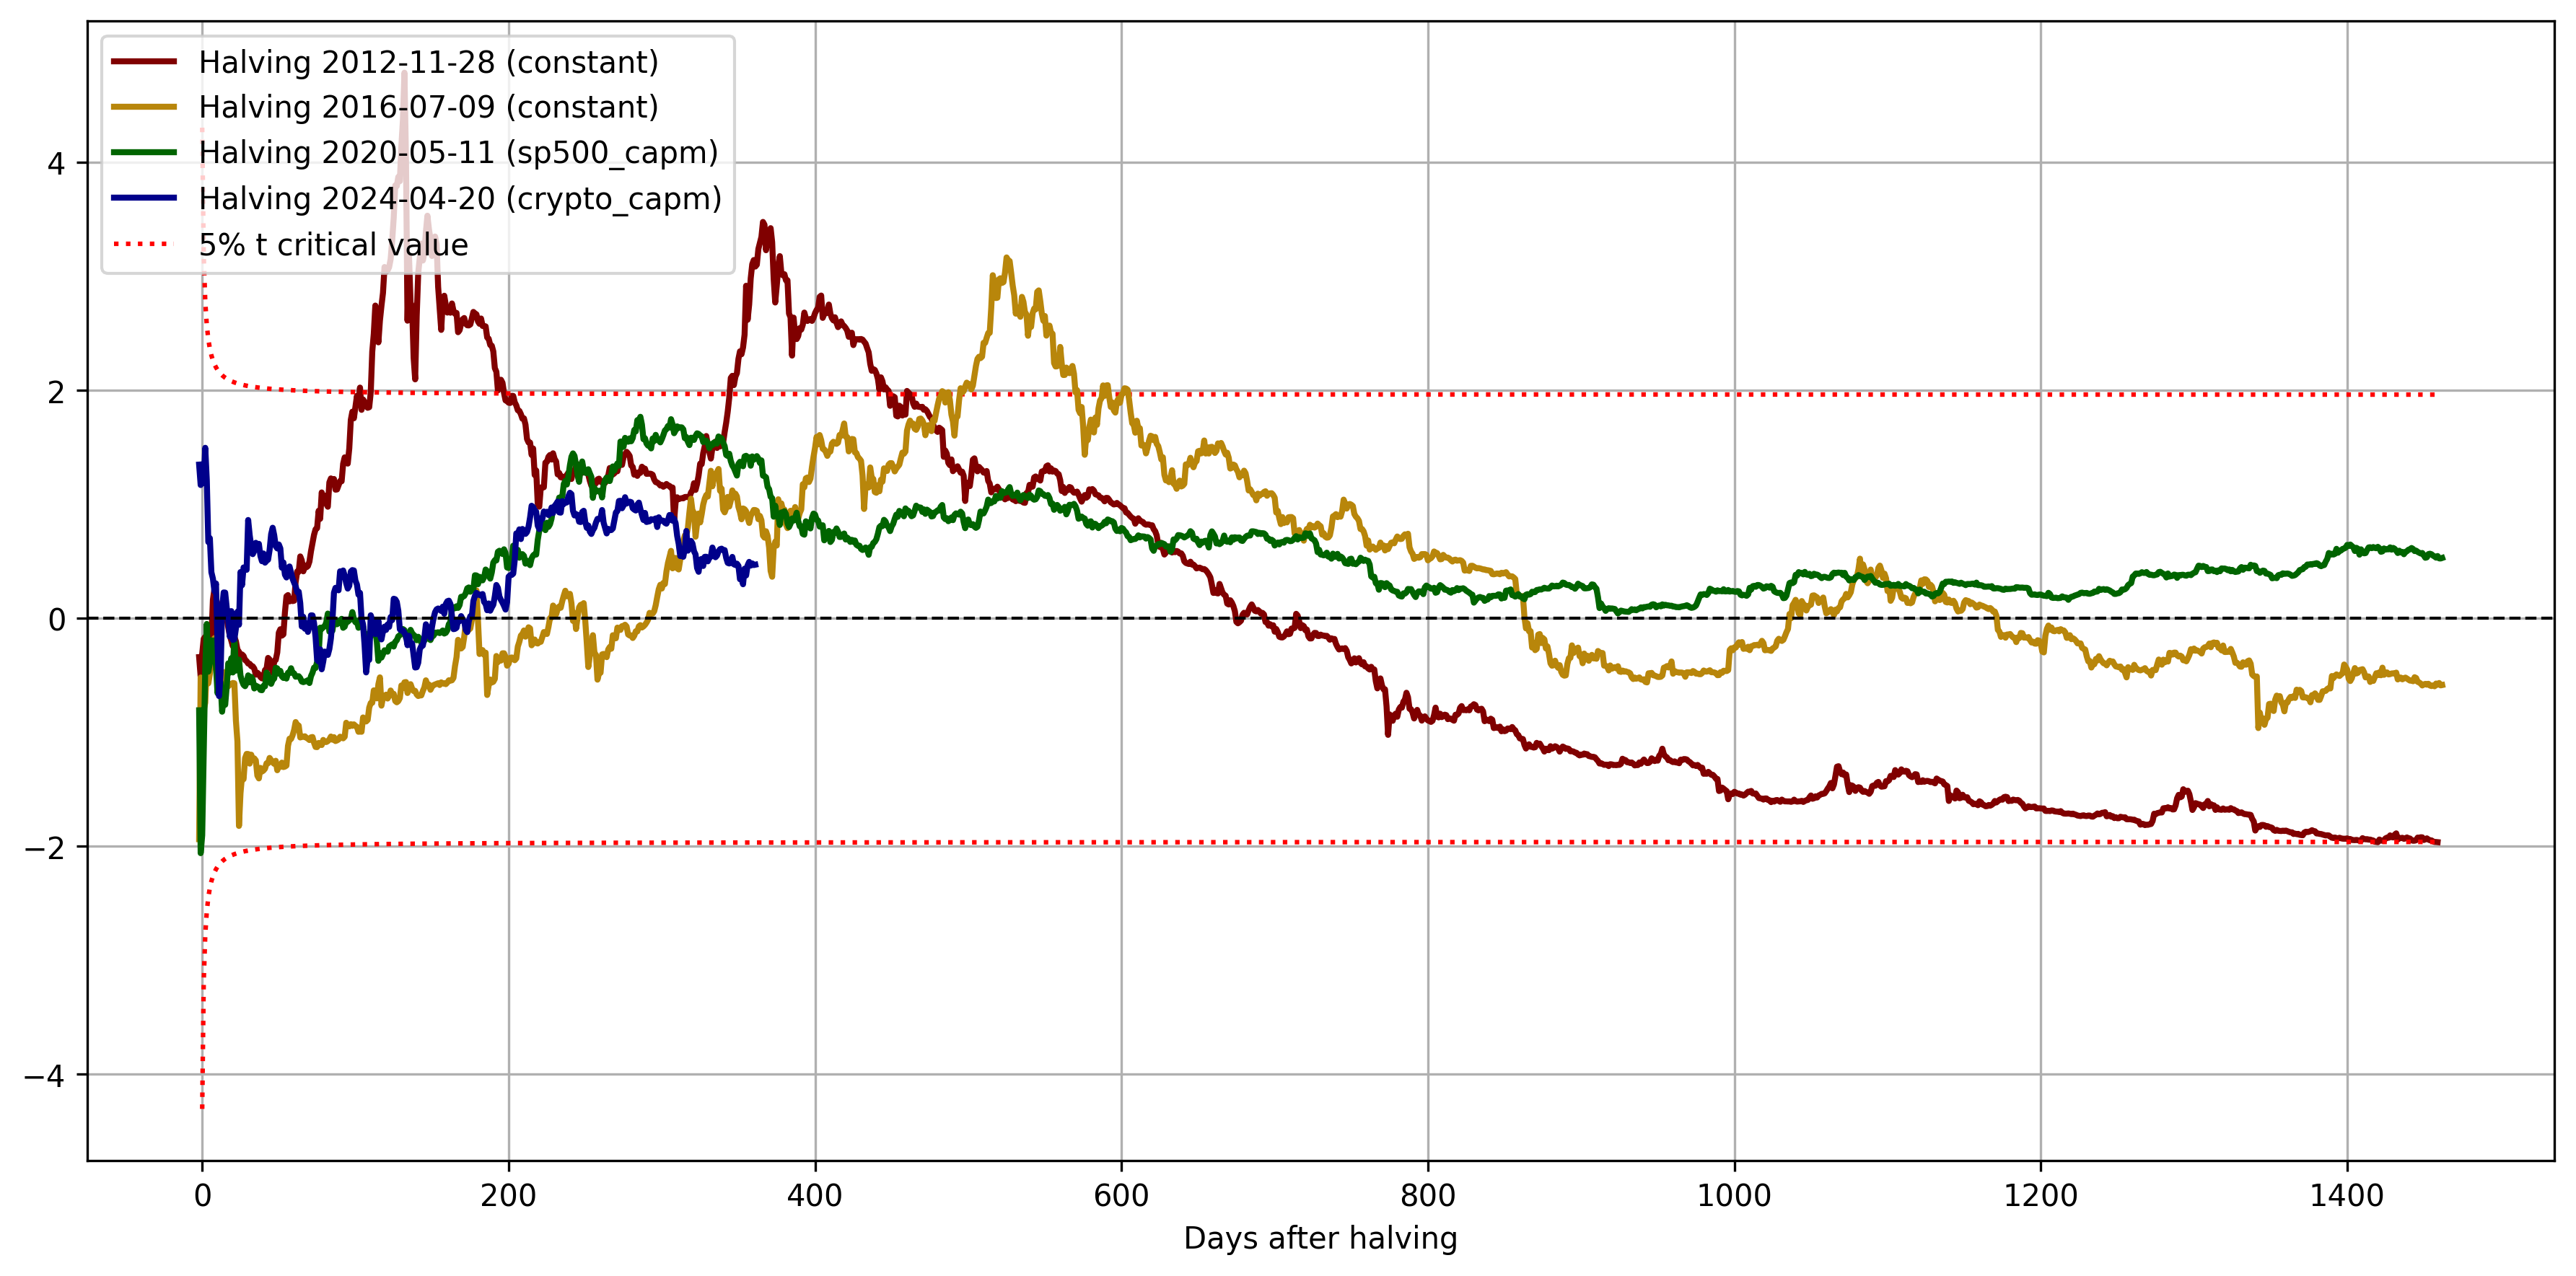

In [24]:
divisors = {
    halving_dates[0].date(): 0.040726,   # 1st halving
    halving_dates[1].date(): 0.029859,   # 2nd halving
    halving_dates[2].date(): 0.048465,   # 3rd halving
    halving_dates[3].date(): 0.028963   # 4th halving
}

plot_t(merged_df, halving_dates, divisors, 1460)

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss
def test_stationarity(series):
    print(f"=== Augmented Dickey-Fuller Test (ADF) ***{series.name}*** ===")
    adf_result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("=> Reject null hypothesis (non-stationary)?", "✅ Yes" if adf_result[1] < 0.05 else "❌ No")
    print()

In [21]:
new_df = merged_df.dropna()

In [22]:
test_stationarity(new_df["crypto_index_diff"]-new_df["rfr"])

=== Augmented Dickey-Fuller Test (ADF) ***None*** ===
ADF Statistic: -16.3891
p-value: 0.0000
=> Reject null hypothesis (non-stationary)? ✅ Yes

